# English to French Translation - Transformer model vs RNN

In [8]:
"""
https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench
https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset
https://www.kaggle.com/code/fareselmenshawii/introduction-to-transformers-machine-translation#Helper-Functions
"""

'\nhttps://www.kaggle.com/datasets/devicharith/language-translation-englishfrench\nhttps://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset\nhttps://www.kaggle.com/code/fareselmenshawii/introduction-to-transformers-machine-translation#Helper-Functions\n'

### Goals of the analysis

Handle sequence-to-sequence translation problems using English-French datasets.
<br>
Preparing efficient datasets with TensorFlow.
<br>
Preparing TensorFlow datasets based on data which does not fit into memory.
<br>
Building a bidirectional encoder-decoder RNN architecture.
<br>
Building a transformer architecture.
<br>
Example sentences translation with above models.

In [9]:
"""
# Import the TensorFlow library
import tensorflow as tf

# Create a TensorFlow session with a configuration that logs device placement
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Import the mixed precision module from the TensorFlow Keras API
from tensorflow.keras import mixed_precision

# Define a mixed precision policy using 'mixed_float16'
policy = mixed_precision.Policy('mixed_float16')

# Set the global policy for mixed precision training
mixed_precision.set_global_policy(policy)
"""

'\n# Import the TensorFlow library\nimport tensorflow as tf\n\n# Create a TensorFlow session with a configuration that logs device placement\nsess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))\n\n# Print the number of available GPUs\nprint("Num GPUs Available: ", len(tf.config.list_physical_devices(\'GPU\')))\n\n# Import the mixed precision module from the TensorFlow Keras API\nfrom tensorflow.keras import mixed_precision\n\n# Define a mixed precision policy using \'mixed_float16\'\npolicy = mixed_precision.Policy(\'mixed_float16\')\n\n# Set the global policy for mixed precision training\nmixed_precision.set_global_policy(policy)\n'

### IMPORTANT!!! Could not upload the dataset with the notebook, you can download the dataset here: https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset
### Make sure to download the 8GB dataset not the 3GB dataset.
### Also make sure to download glove.6B.100d from: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

### Creating Spark Session

In [10]:
# Import the TensorFlow library
import tensorflow as tf

# Import the findspark library, which helps locate the Spark installation
import findspark

# Initialize findspark to set up the necessary environment variables
findspark.init()

# Find the location of the Spark installation and return it as a string
spark_location = findspark.find()

# Import the pyspark library to use Spark functionality
import pyspark

# Find the location of the Spark installation again (after importing pyspark)
spark_location_after_import = findspark.find()

# Print the version of PySpark that is currently installed
print(pyspark.__version__)


3.4.1


In [11]:
# Import PySpark
from pyspark.sql import SparkSession

#Create SparkSession
spark = SparkSession.builder \
    .appName('English_to_French.com') \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

In [12]:
# Import the 'platform' module, which provides information about the host operating system
import platform

# Use the 'platform.java_ver()' function to get information about the Java version

# Print the Java version information
print(platform.java_ver())


('', '', ('', '', ''), ('', '', ''))


### Importing Data and pip installs

In [13]:

# Read a CSV file into a PySpark DataFrame

# Use the 'spark' object (assumed to be a SparkSession) to read a CSV file
# './en-fr.csv' is the file path to the CSV file to be read
# 'header=True' specifies that the first row of the CSV file contains column headers
# 'escape="\""' is used to specify the escape character for special characters in the CSV file (e.g., "\"")
df = spark.read.csv('./en-fr.csv', header=True, escape="\"")

# Limit the DataFrame to the first 500,001 rows

# Use the 'limit' function to restrict the DataFrame to a specific number of rows (500,001 in this case)
df = df.limit(500001)

# Show the contents of the DataFrame

# Use the 'show' function to display the contents of the DataFrame in a tabular format
df.show()

+--------------------+--------------------+
|                  en|                  fr|
+--------------------+--------------------+
|Changing Lives | ...|Il a transformé n...|
|            Site map|        Plan du site|
|            Feedback|         Rétroaction|
|             Credits|             Crédits|
|            Français|             English|
+--------------------+--------------------+



In [14]:
pip install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install --upgrade numpy

  Using cached numpy-1.25.2-cp39-cp39-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\storm\\Anaconda\\Lib\\site-packages\\~-9py\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [16]:
pip install --upgrade seaborn

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install numpy scipy matplotlib

  Using cached numpy-1.24.4-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.
tensorflow-intel 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.10.0 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.


### Exploratory data analysis (EDA)

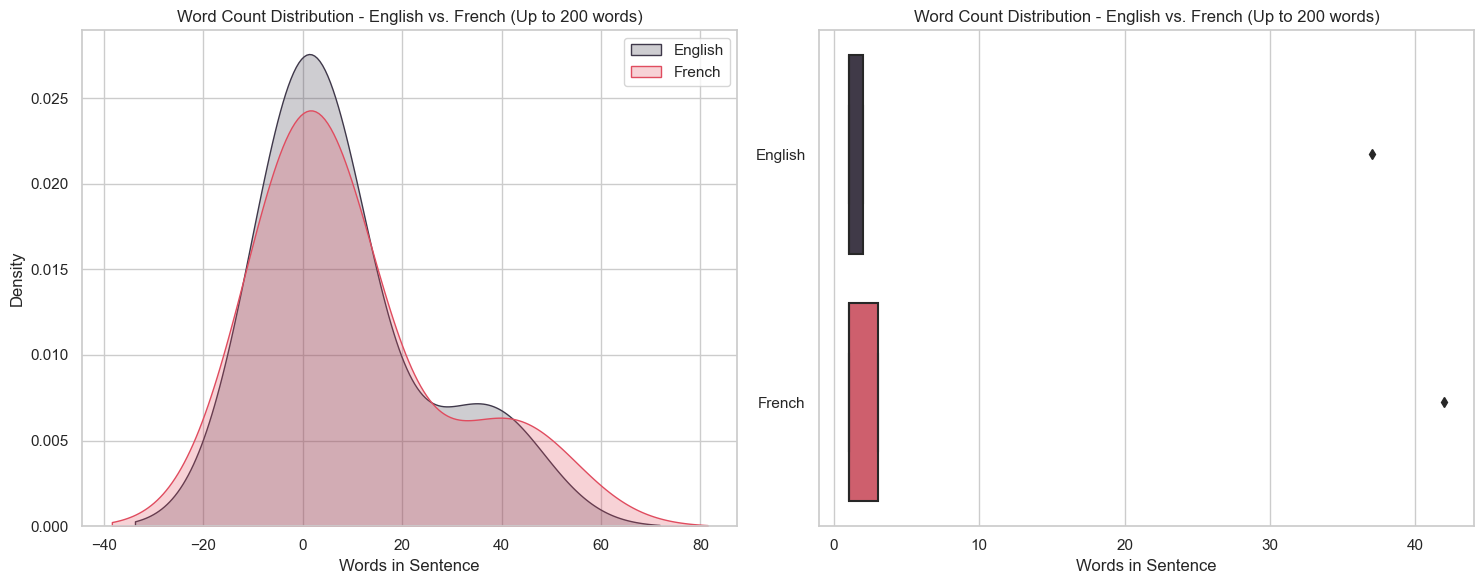

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyspark.sql.functions as F

# Using the'text' column in the DataFrame that contains sentences
# Tokenize the sentences into words and count the number of words in each sentence
df_graph1 = df.withColumn("english_word_count", F.size(F.split(df["en"], " ")))
df_graph2 = df.withColumn("french_word_count", F.size(F.split(df["fr"], " ")))

# Create two DataFrames for English and French word counts
english_word_counts = df_graph1.select("english_word_count").rdd.flatMap(lambda x: x).collect()
french_word_counts = df_graph2.select("french_word_count").rdd.flatMap(lambda x: x).collect()

# Convert the word count lists to NumPy arrays
english_word_counts = np.array(english_word_counts)
french_word_counts = np.array(french_word_counts)

# Set a seaborn style for better appearance
sns.set(style="whitegrid")

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Filter the data to consider only words up to a maximum of 200 words
english_word_counts_filtered = english_word_counts[english_word_counts <= 120]
french_word_counts_filtered = french_word_counts[french_word_counts <= 120]

# Plot Kernel Density Estimation (KDE) plots with filled areas on the first axis
sns.kdeplot(english_word_counts_filtered, fill=True, color='#3f384a', label='English', ax=ax1)
sns.kdeplot(french_word_counts_filtered, fill=True, color='#e04c5f', label='French', ax=ax1)

# Create a box and whisker plot with swapped axes on the second axis
sns.boxplot(data=[english_word_counts_filtered, french_word_counts_filtered], palette=['#3f384a', '#e04c5f'], orient='h', ax=ax2)
ax2.set_yticklabels(['English', 'French'])
ax2.set_xlabel("Words in Sentence")
ax2.set_title("Word Count Distribution - English vs. French (Up to 200 words)")

# Customize the appearance of the first axis
ax1.set_xlabel("Words in Sentence")
ax1.set_ylabel("Density")
ax1.set_title("Word Count Distribution - English vs. French (Up to 200 words)")
ax1.legend()

plt.tight_layout()
plt.show()

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [20]:
# "en" column
df_word_1 = df.select("en")
# "fr" column
df_word_2 = df.select("fr")

In [21]:
# Combine the "en" and "fr" column into a single string
text1 = " ".join(df_word_1.rdd.flatMap(lambda x: x).collect())
text2 = " ".join(df_word_2.rdd.flatMap(lambda x: x).collect())

In [22]:
# Create a WordCloud object
wordcloud1 = WordCloud(width=800, height=400, background_color="white")
wordcloud2 = WordCloud(width=800, height=400, background_color="white")

In [23]:
# Generate the word cloud image
wordcloud1.generate(text1)
wordcloud2.generate(text2)

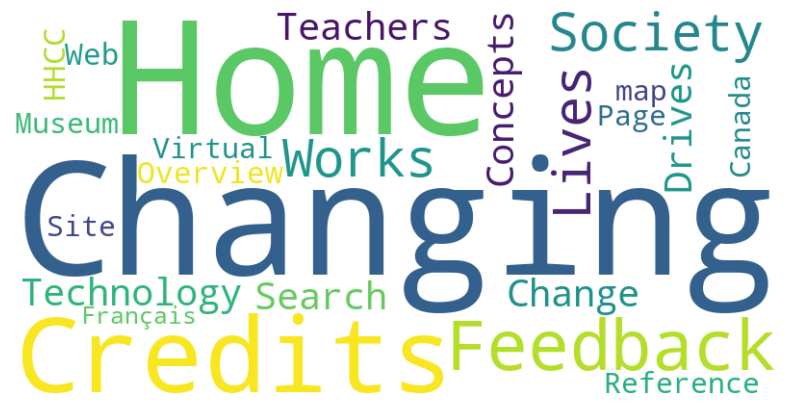

In [24]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()

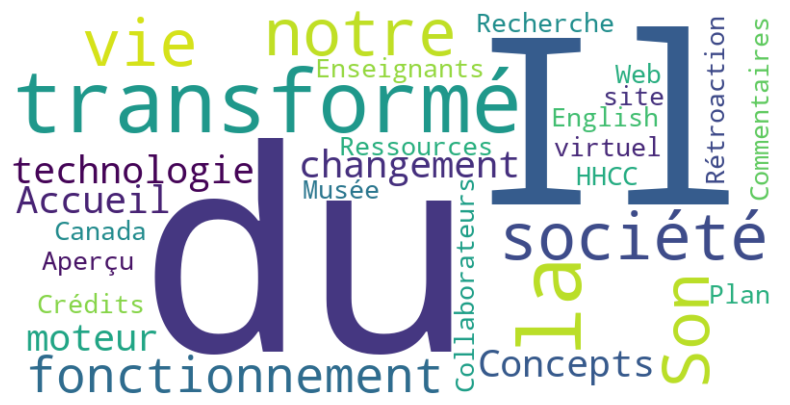

In [25]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

### Pre-processing the data

In [26]:
# Import the Tokenizer module from the TensorFlow Keras library for text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer

# Select the "en" column from the DataFrame 'df' and store it in 'english_sentences'
english_sentences = df.select("en")

# Select the "fr" column from the DataFrame 'df' and store it in 'french_sentences'
french_sentences = df.select("fr")

# Extract and collect the English and French sentences from their respective DataFrames

# Extract and collect the English sentences as a list
english_sentences = english_sentences.rdd.map(lambda x: x[0]).collect()

# Extract and collect the French sentences as a list
french_sentences = french_sentences.rdd.map(lambda x: x[0]).collect()


In [27]:
# Set the maximum number of words to consider in the English vocabulary
num_words = 5000

# Initialize a tokenizer for English text with specific filters
tokenizer_en = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')

# Fit the tokenizer on English sentences to generate a word index
tokenizer_en.fit_on_texts(english_sentences)

# Convert the English sentences into sequences of tokenized words
english_sentences = tokenizer_en.texts_to_sequences(english_sentences)

# Get the word index generated by the tokenizer
word_index = tokenizer_en.word_index

# Print the number of words in the English vocabulary
print(f"The number of words in the English vocabulary: {len(word_index)}")


The number of words in the English vocabulary: 27


In [28]:
# Create a tokenizer for tokenizing French sentences

# Initialize a tokenizer named 'tokenizer_fr' with a specified vocabulary size (num_words)
# and a set of characters to be filtered out from the text data
tokenizer_fr = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')

# Fit the tokenizer on the French sentences to build a vocabulary
tokenizer_fr.fit_on_texts(french_sentences)

# Tokenize the French sentences using the fitted tokenizer
french_sentences = tokenizer_fr.texts_to_sequences(french_sentences)

# Get the word index from the tokenizer, which maps words to unique integer IDs
word_index_fr = tokenizer_fr.word_index

# Print the number of words in the French vocabulary
print(f"The number of words in the French vocabulary: {len(word_index_fr)}")

The number of words in the French vocabulary: 31


In [29]:
# Import the pad_sequences function from TensorFlow's Keras preprocessing module
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length for sentences
max_sequence_length = 30

# Pad the sequences of English sentences to the specified maximum length
# - english_sentences: The input sequences of English sentences
# - maxlen: The maximum length to pad/cut the sequences to (in this case, 30)
# - padding: 'post' indicates padding will be added at the end of sequences
# - truncating: 'post' indicates truncation will be performed at the end of sequences
english_sentences = pad_sequences(english_sentences, maxlen=max_sequence_length, padding='post', truncating='post')

# Pad the sequences of French sentences to the specified maximum length
# - french_sentences: The input sequences of French sentences
# - maxlen: The maximum length to pad/cut the sequences to (in this case, 30)
# - padding: 'post' indicates padding will be added at the end of sequences
# - truncating: 'post' indicates truncation will be performed at the end of sequences
french_sentences = pad_sequences(french_sentences, maxlen=max_sequence_length, padding='post', truncating='post')


### RNN Model training and testing

In [30]:
# Import necessary Keras modules
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, LSTM, Dropout
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

# Define a function that creates a Bidirectional LSTM-based model
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    # Set the learning rate for the optimizer
    learning_rate = 0.003
    
    # Build the layers of the model
    model = Sequential()
    
    # Add an Embedding layer with input size and embedding dimension
    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1], input_shape=input_shape[1:]))
    
    # Add a Bidirectional GRU layer with 128 units and return sequences
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    
    # Add a TimeDistributed Dense layer with 1024 units and ReLU activation
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    
    # Add a Dropout layer to prevent overfitting
    model.add(Dropout(0.5))
    
    # Add another TimeDistributed Dense layer with output size and softmax activation
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile the model with specified loss function, optimizer, and metrics
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    # Return the created model
    return model


In [31]:
# Define a function named 'pad' with two parameters: 'x' and 'length'.
def pad(x, length=None):
    # Check if the 'length' parameter is None.
    if length is None:
        # If 'length' is None, calculate it as the maximum length of sentences in 'x'.
        length = max([len(sentence) for sentence in x])
    
    # Call the 'pad_sequences' function with the following arguments:
    # - 'x': The input data to be padded.
    # - 'maxlen': The maximum length to which each sentence in 'x' should be padded (set to 30).
    # - 'padding': Specifies that padding should be added at the end of each sentence ('post').
    # - 'truncating': Specifies that any content exceeding 'maxlen' should be truncated from the end ('post').
    # The result is returned by the 'pad' function.
    return pad_sequences(x, maxlen=30, padding='post', truncating='post')


In [32]:
"""
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
"""
# Determine the maximum sequence length for both English and French sentences
max_sequence_length = 30

# Pad English and French sentences to the same maximum sequence length
english_sentences = pad(english_sentences, length=max_sequence_length)
french_sentences = pad(french_sentences, length=max_sequence_length)

# Reshape the input
tmp_x = english_sentences  # No need to re-pad, it's already done
tmp_x = tmp_x.reshape((-1, max_sequence_length))

# Create and compile a neural network model

# Initialize a neural network model using 'bd_model' with the following parameters:
# - Input shape: tmp_x.shape
# - Output shape: french_sentences.shape[1]
# - Input vocabulary size: len(tokenizer_en.word_index)+1
# - Output vocabulary size: len(tokenizer_fr.word_index)+1
model = bd_model(
    tmp_x.shape,
    french_sentences.shape[1],
    len(tokenizer_en.word_index)+1,
    len(tokenizer_fr.word_index)+1)

# Display a summary of the model architecture
model.summary()

# Train the model

# Fit (train) the model using the following parameters:
# - Input data: tmp_x
# - Target data: french_sentences
# - Batch size: 64
# - Number of epochs: 10
# - Validation split: 20% of the data
model.fit(tmp_x, french_sentences, batch_size=64, epochs=10, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           3584      
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          198144    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 30, 1024)         263168    
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 30, 1024)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 32)           32800     
 tributed)                                                       
                                                        

In [33]:
# Define a function named translate_sentence that takes an input sentence, a model, a tokenizer, and a maximum sequence length as input parameters
def translate_sentence(input_sentence, model, tokenizer, max_sequence_length):
    # Tokenize and pad the input sentence
    
    # Tokenize the input sentence into sequences of integers
    input_sequence = tokenizer.texts_to_sequences([input_sentence])
    
    # Pad the input sequence to the specified maximum sequence length
    input_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Use the model to generate the translation
    
    # Generate a translated sequence using the provided model
    translated_sequence = model.predict(input_sequence)
    
    # Convert the translated sequence back to text
    translated_sentence = []
    
    # Iterate through the tokens in the translated sequence
    for token_ids in translated_sequence[0]:
        if np.argmax(token_ids) == 0:
            # Skip padding tokens (ID 0)
            continue
        token = tokenizer.index_word.get(np.argmax(token_ids))
        if token == '<EOS>':  # Check for the end of sentence token
            break
        if token is not None:
            translated_sentence.append(token)
    
    # Join the translated tokens to form the final translated sentence
    return ' '.join(translated_sentence)

# Test the model with an input sentence

# Define an input sentence to be translated
input_sentence = "new jersey est parfois calme pendant l'automne"

# Call the translate_sentence function with the input sentence, model, tokenizer, and max sequence length
translation = translate_sentence(input_sentence, model, tokenizer_fr, max_sequence_length)

# Print the input sentence and its translation
print(f"Input sentence: {input_sentence}")
print(f"Translation: {translation}")

1/1 [==============================] - 0s 470ms/step
Input sentence: new jersey est parfois calme pendant l'automne
Translation: 


### Transformer model training and testing

In [34]:
# Import necessary modules from TensorFlow
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization

# Define a function named 'get_angles' for computing angles for positional encoding
def get_angles(pos, i, embedding_dim):
    """
    Function to compute the angles for positional encoding.
    
    Arguments:
    - pos: Positional index (integer) for which to compute the angle.
    - i: Dimension index (integer) for the angle computation.
    - embedding_dim: The dimension of the embedding for which the angle is computed.
    
    Returns:
    - The angle computed based on the given positional index, dimension index, and embedding dimension.
    """
    
    # Compute angle rates based on the formula 1 / (10000^(2 * (i//2) / embedding_dim))
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embedding_dim))
    
    # Compute and return the angle by multiplying the positional index (pos) with the angle rates
    return pos * angle_rates

In [35]:
def positional_encoding(position, embedding_dim):
    """
    Adds positional encoding to the embeddings to be fed into the Transformer model.
    
    This function computes sinusoidal positional encodings based on the positions and dimensions of the embeddings
    and adds these values to the embeddings.

    Args:
    - position: The position index of the embeddings (integer).
    - embedding_dim: The dimensionality of the embeddings (integer).

    Returns:
    - pos_encoding: A tensor containing the positional encodings for the given positions and dimensions.

    It uses a mathematical formula to calculate the sinusoidal values and adds them to the embeddings.
    """
    # Calculate the angles for the positional encodings using the get_angles() function
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                           np.arange(embedding_dim)[np.newaxis, :], embedding_dim)
    
    # Apply sine (sin) function to even indices in the angle_rads array (i.e., 2i)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cosine (cos) function to odd indices in the angle_rads array (i.e., 2i+1)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # Create a positional encoding tensor by adding angle_rads as a new axis
    pos_encoding = angle_rads[np.newaxis, ...]
    
    # Cast the positional encoding tensor to a specific data type (float32)
    return tf.cast(pos_encoding, dtype=tf.float32)


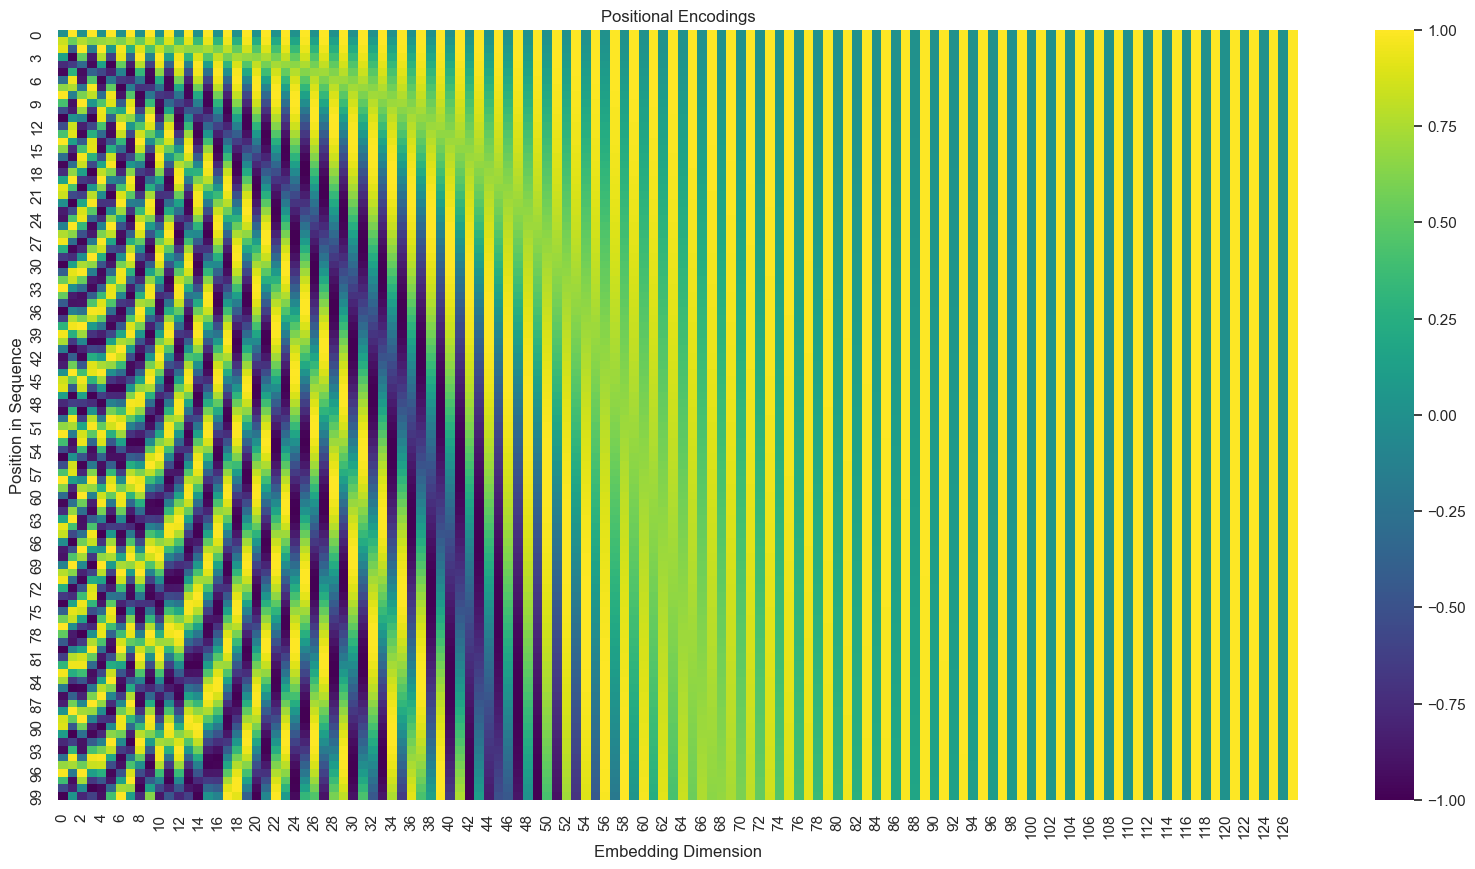

In [36]:
# Generate positional encodings
pos_encodings = positional_encoding(100, 128)

# Visualize the encodings as a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pos_encodings[0], cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

In [37]:
def create_padding_mask(seq):
    """
    Creates a padding mask for a given sequence.
    
    Args:
        seq (tensor): A tensor of shape (batch_size, seq_len) containing the sequence.
        
    Returns:
        A tensor of shape (batch_size, 1, 1, seq_len) containing a mask that is 1 where the sequence is padded, and 0 otherwise.
    """
    # Convert the sequence to a boolean tensor where True indicates a pad token (value 0).
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # Add an extra dimension to the mask to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]

In [38]:
def create_look_ahead_mask(size):
    """
    Creates a look-ahead mask used during training the decoder of a transformer.

    Args:
        size (int): The size of the mask.

    Returns:
        tf.Tensor: A lower triangular matrix of shape (size, size) with ones on the diagonal
            and zeros below the diagonal.
    """
    # create a matrix with ones on the diagonal and zeros below the diagonal
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask

In [39]:
def create_masks(inputs, targets):
    """
    Creates masks for the input sequence and target sequence.
    
    Args:
        inputs: Input sequence tensor.
        targets: Target sequence tensor.
    
    Returns:
        A tuple of three masks: the encoder padding mask, the combined mask used in the first attention block, 
        and the decoder padding mask used in the second attention block.
    """
    
    # Create the encoder padding mask.
    enc_padding_mask = create_padding_mask(inputs)
        
    # Create the decoder padding mask.
    dec_padding_mask = create_padding_mask(inputs)
        
    # Create the look ahead mask for the first attention block.
    # It is used to pad and mask future tokens in the tokens received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
    
    # Create the decoder target padding mask.
    dec_target_padding_mask = create_padding_mask(targets)
    
    # Combine the look ahead mask and decoder target padding mask for the first attention block.
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
    return enc_padding_mask, combined_mask, dec_padding_mask

In [40]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Computes the scaled dot product attention weight for the query (q), key (k), and value (v) vectors. 
    The attention weight is a measure of how much focus should be given to each element in the sequence of values (v) 
    based on the corresponding element in the sequence of queries (q) and keys (k).
    
    Args:
    q: query vectors; shape (..., seq_len_q, depth)
    k: key vectors; shape  (..., seq_len_k, depth)
    v: value vectors; shape  (..., seq_len_v, depth_v)
    mask: (optional) mask to be applied to the attention weights
    
    Returns:
    output: The output of the scaled dot product attention computation; shape   (..., seq_len_q, depth_v)
    attention_weights: The attention weights
    """
    # Compute dot product of query and key vectors
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # Compute the square root of the depth of the key vectors
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    
    # Compute scaled attention logits by dividing dot product by scaled dk
    scaled_attention_logits = matmul_qk / scaled_dk
    
    # Apply mask to the attention logits (if mask is not None)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # Apply softmax to the scaled attention logits to get the attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # Compute the weighted sum of the value vectors using the attention weights
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [41]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    MultiHeadAttention Layer that implements the attention mechanism for the Transformer.
    It splits the input into multiple heads, computes scaled dot-product attention for each head
    and then concatenates the output of the heads and passes it through a dense layer.
    """

    def __init__(self, key_dim, num_heads, dropout_rate=0.0):
        """
        Initializes the MultiHeadAttention layer.
    
        Args:
            key_dim (int): The dimensionality of the key space.
            num_heads (int): The number of attention heads.
            dropout (float): The dropout rate to apply after the dense layer.
        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        #  ensure  that the dimension of the embedding can be evenly split across attention heads
        assert key_dim % num_heads == 0 
        self.depth = self.key_dim // self.num_heads
        
        # dense layers to project the input into queries, keys and values
        self.wq = Dense(key_dim)
        self.wk = Dense(key_dim)
        self.wv = Dense(key_dim)
    
        # dropout layer
        self.dropout = Dropout(dropout_rate)
    
        # dense layer to project the output of the attention heads
        self.dense = Dense(key_dim)
        
    def split_heads(self, x, batch_size):
        """
        Splits the last dimension of the tensor into (num_heads, depth).
        Transposes the result such that the shape is (batch_size, num_heads, seq_len, depth).
    
        Args:
            x (tensor): The tensor to be split.
            batch_size (int): The size of the batch.
    
        Returns:
            tensor: The tensor with the last dimension split into (num_heads, depth) and transposed.
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask=None):
        """
        Applies the multi-head attention mechanism to the inputs.
    
        Args:
            v (tensor): The value tensor of shape (batch_size, seq_len_v, key_dim).
            k (tensor): The key tensor of shape (batch_size, seq_len_k, key_dim).
            q (tensor): The query tensor of shape (batch_size, seq_len_q, key_dim).
            mask (tensor, optional): The mask tensor of shape (batch_size, seq_len_q, seq_len_k).
                                     Defaults to None.
    
        Returns:
            tensor: The output tensor of shape (batch_size, seq_len_q, key_dim).
            tensor: The attention weights tensor of shape (batch_size, num_heads, seq_len_q, seq_len_k).
        """
        batch_size = tf.shape(q)[0]
        
        # Dense on the q, k, v vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # split the queries, keys and values into multiple heads
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output)
        
        return output, attention_weights

In [42]:
def FeedForward(embedding_dim, fully_connected_dim):
    """Create a fully connected feedforward neural network.
    
    Args:
        embedding_dim (int): Dimensionality of the embedding output from the transformer layer.
        fully_connected_dim (int): Number of neurons in the fully connected layers.
    
    Returns:
        tf.keras.Sequential: A fully connected feedforward neural network with the specified architecture.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])
    return model

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """Initializes the encoder layer
        
        Args: 
            embedding_dim: The dimensionality of the input and output of this layer
            num_heads: The number of attention heads to use in the multi-head attention layer
            fully_connected_dim: The dimensionality of the hidden layer in the feedforward network
            dropout_rate: The rate of dropout to apply to the output of this layer during training
            
        Returns:
            A new instance of the EncoderLayer class
        """
        super(EncoderLayer, self).__init__()
        
        # Multi-head self-attention mechanism
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout = Dropout(dropout_rate)
        
        # Feedforward network
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
    def call(self, x, training, mask):
        """Applies the encoder layer to the input tensor
        
        Args:
            x: The input tensor to the encoder layer
            training: A boolean indicating whether the model is in training mode
            mask: A tensor representing the mask to apply to the attention mechanism
            
        Returns:
            The output of the encoder layer after applying the multi-head attention and feedforward network
        """
        
        # Apply multi-head self-attention mechanism to input tensor
        attn_output, _ = self.mha(x, x, x, mask)
        
        # Apply first layer normalization and add residual connection
        out1 = self.layernorm1(attn_output + x)
        
        # Apply feedforward network to output of first layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        
        # Apply second layer normalization and add residual connection
        out2 = self.layernorm2(ffn_output + out1)
        
        return out2

In [44]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        """
        Initializes the Encoder layer of the Transformer model.
        
        Args:
            num_layers (int): Number of EncoderLayers to stack.
            embedding_dim (int): Dimensionality of the token embedding space.
            num_heads (int): Number of attention heads to use in MultiHeadAttention layers.
            fully_connected_dim (int): Dimensionality of the fully connected layer in the EncoderLayer.
            input_vocab_size (int): Size of the input vocabulary.
            maximum_position_encoding (int): Maximum length of input sequences for positional encoding.
            dropout_rate (float): Probability of dropping out units during training.

        """
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        # Embedding layer
        self.embedding = Embedding(input_vocab_size, embedding_dim)
        
        # Positional encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        
        # Encoder layers
        self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate) for _ in range(num_layers)]
        
        # Dropout layer
        self.dropout = Dropout(dropout_rate)
        
    def call(self, inputs, training, mask):
        """
        Call function for the Encoder layer.
        
        Args:
            inputs: tensor of shape (batch_size, sequence_length) representing input sequences
            training: boolean indicating if the model is in training mode
            mask: tensor of shape (batch_size, sequence_length) representing the mask to apply to the input sequence

        Returns:
            A tensor of shape (batch_size, sequence_length, embedding_dim) representing the encoded sequence
        """

        # Get the sequence length
        seq_len = tf.shape(inputs)[1]

        # Embed the input sequence
        inputs = self.embedding(inputs)

        # Scale the embeddings by sqrt(embedding_dim)
        inputs *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add positional encodings to the input sequence
        inputs += self.pos_encoding[:, :seq_len, :]

        # Apply dropout to the input sequence
        inputs = self.dropout(inputs, training=training)

        # Pass the input sequence through the encoder layers
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training, mask)

        # Return the encoded sequence
        return inputs

In [45]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """
        Initializes a single decoder layer of the transformer model.
        
        Args:
        embedding_dim: The dimension of the embedding space.
        num_heads: The number of attention heads to use.
        fully_connected_dim: The dimension of the feedforward network.
        rate: The dropout rate for regularization.
        """
        super(DecoderLayer, self).__init__()
        
        # Instantiate two instances of MultiHeadAttention.
        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        # Instantiate a fully connected feedforward network.
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
        # Instantiate three layer normalization layers with epsilon=1e-6.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        # Instantiate a dropout layer for regularization.
        self.dropout3 = Dropout(dropout_rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass through the decoder layer.
        
        Args:
        x: The input to the decoder layer, a query vector.
        enc_output: The output from the top layer of the encoder, a set of attention vectors k and v.
        training: Whether to apply dropout regularization.
        look_ahead_mask: The mask to apply to the input sequence so that it can't look ahead to future positions.
        padding_mask: The mask to apply to the input sequence to ignore padding tokens.
        
        Returns:
        The output from the decoder layer, a tensor with the same shape as the input.
        The attention weights from the first multi-head attention layer.
        The attention weights from the second multi-head attention layer.
        """
        
        # Apply the first multi-head attention layer to the query vector x.
        # We pass x as all three inputs to the layer because this is a self-attention layer.
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        
        # Add the original input to the output of the attention layer and apply layer normalization.
        out1 = self.layernorm1(attn1 + x) 
        
        # Apply the second multi-head attention layer to the output from the first layer and the encoder output.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        
        # Add the output from the first layer to the output of the second layer and apply layer normalization.
        out2 = self.layernorm2(attn2 + out1)
        
        # Apply the feedforward network to the output of the second layer and apply dropout regularization.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # Add the output from the second layer to the output of the feedforward network and apply layer normalization.
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [46]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """
        Initializes a single decoder layer of the transformer model.
        
        Args:
        embedding_dim: The dimension of the embedding space.
        num_heads: The number of attention heads to use.
        fully_connected_dim: The dimension of the feedforward network.
        rate: The dropout rate for regularization.
        """
        super(DecoderLayer, self).__init__()
        
        # Instantiate two instances of MultiHeadAttention.
        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        # Instantiate a fully connected feedforward network.
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
        # Instantiate three layer normalization layers with epsilon=1e-6.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        # Instantiate a dropout layer for regularization.
        self.dropout3 = Dropout(dropout_rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass through the decoder layer.
        
        Args:
        x: The input to the decoder layer, a query vector.
        enc_output: The output from the top layer of the encoder, a set of attention vectors k and v.
        training: Whether to apply dropout regularization.
        look_ahead_mask: The mask to apply to the input sequence so that it can't look ahead to future positions.
        padding_mask: The mask to apply to the input sequence to ignore padding tokens.
        
        Returns:
        The output from the decoder layer, a tensor with the same shape as the input.
        The attention weights from the first multi-head attention layer.
        The attention weights from the second multi-head attention layer.
        """
        
        # Apply the first multi-head attention layer to the query vector x.
        # We pass x as all three inputs to the layer because this is a self-attention layer.
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        
        # Add the original input to the output of the attention layer and apply layer normalization.
        out1 = self.layernorm1(attn1 + x) 
        
        # Apply the second multi-head attention layer to the output from the first layer and the encoder output.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        
        # Add the output from the first layer to the output of the second layer and apply layer normalization.
        out2 = self.layernorm2(attn2 + out1)
        
        # Apply the feedforward network to the output of the second layer and apply dropout regularization.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # Add the output from the second layer to the output of the feedforward network and apply layer normalization.
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        """
        Initializes the Decoder object.
        
        Args:
            num_layers (int): The number of Decoder layers.
            embedding_dim (int): The size of the embedding dimension.
            num_heads (int): The number of heads in the MultiHeadAttention layer.
            fully_connected_dim (int): The number of units in the feedforward network.
            target_vocab_size (int): The number of words in the target vocabulary.
            maximum_position_encoding (int): The maximum length of a sequence.
            dropout_rate (float): The rate at which to apply dropout.
        """
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        # create layers
        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Executes the Decoder.

        Args:
            x (tf.Tensor): The input to the Decoder.
            enc_output (tf.Tensor): The output from the Encoder.
            training (bool): Whether the Decoder is in training mode.
            look_ahead_mask (tf.Tensor): The mask for self-attention in the MultiHeadAttention layer.
            padding_mask (tf.Tensor): The mask for padding in the MultiHeadAttention layer.

        Returns:
            tf.Tensor: The output from the Decoder.
            dict: A dictionary of attention weights.
        """
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # apply each layer of the decoder
        for i in range(self.num_layers):
            # pass through decoder layer i
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            # record attention weights for block1 and block2
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2

        return x, attention_weights

In [47]:
class Transformer(tf.keras.Model):
    """
    A Transformer model that takes in an input and target sequence and outputs a final prediction.

    Args:
        num_layers (int): Number of layers in the Encoder and Decoder.
        embedding_dim (int): Dimensionality of the embedding layer.
        num_heads (int): Number of attention heads used in the Transformer.
        fully_connected_dim (int): Dimensionality of the fully connected layer in the Encoder and Decoder.
        input_vocab_size (int): Size of the input vocabulary.
        target_vocab_size (int): Size of the target vocabulary.
        max_positional_encoding_input (int): Maximum length of the input sequence.
        max_positional_encoding_target (int): Maximum length of the target sequence.
        dropout_rate (float, optional): Dropout rate used in the Encoder and Decoder layers. Defaults to 0.1.
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, target_vocab_size, max_positional_encoding_input, max_positional_encoding_target, dropout_rate=0.1):
        super(Transformer, self).__init__()
        
        # Initialize the Encoder and Decoder layers
        self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_input, dropout_rate)
        self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_target, dropout_rate)
        
        # Add a final dense layer to make the final prediction
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Perform a forward pass through the Transformer model.

        Args:
            inp (tf.Tensor): Input sequence tensor with shape (batch_size, input_seq_len).
            tar (tf.Tensor): Target sequence tensor with shape (batch_size, target_seq_len).
            training (bool): Whether the model is being trained or not.
            enc_padding_mask (tf.Tensor): Padding mask for the Encoder with shape (batch_size, 1, 1, input_seq_len).
            look_ahead_mask (tf.Tensor): Mask to prevent the Decoder from looking ahead in the target sequence with shape (batch_size, 1, target_seq_len, target_seq_len).
            dec_padding_mask (tf.Tensor): Padding mask for the Decoder with shape (batch_size, 1, 1, target_seq_len).

        Returns:
            tuple: A tuple containing the final output of the model and the attention weights of the Decoder.
        """
        # Pass the input sequence through the Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # Pass the target sequence and the output of the Encoder through the Decoder
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # Pass the output of the Decoder through the final dense layer to get the final prediction
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [48]:
# Set hyperparameters for the Transformer model
embedding_dim = 256  # dimensionality of the embeddings used for tokens in the input and target sequences
fully_connected_dim = 512  # dimensionality of the hidden layer of the feedforward neural network within the Transformer block
num_layers = 4  # number of Transformer blocks in the encoder and decoder stacks
num_heads = 8  # number of heads in the multi-head attention mechanism
dropout_rate = 0.1  # dropout rate for regularization

# Set vocabulary sizes for input and target sequences
input_vocab_size = len(tokenizer_fr.word_index) + 2  # add 2 for the start and end tokens
target_vocab_size = len(tokenizer_en.word_index) + 2  # add 2 for the start and end tokens

# Set maximum positional encoding values for input and target sequences
max_positional_encoding_input = input_vocab_size  # maximum positional encoding value for input sequence
max_positional_encoding_target = target_vocab_size  # maximum positional encoding value for target sequence

# Set the number of epochs and batch size for training
EPOCHS = 10
batch_size = 64

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    A custom learning rate schedule that uses a combination of
    a square root inverse decay and a warmup schedule.

    Args:
        embedding_dim (int): The dimension of the embedding.
        warmup_steps (int): The number of steps used for warmup.

    Returns:
        float: The learning rate value at a given step.
    """
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):
        """
        Compute the learning rate value for a given step using
        a combination of square root inverse decay and warmup.

        Args:
            step (int): The current step number.

        Returns:
            float: The learning rate value at the current step.
        """
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

# Create an instance of the custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)

In [50]:
# Create an instance of the Transformer model
transformer = Transformer(num_layers, embedding_dim, num_heads,
                           fully_connected_dim, input_vocab_size, target_vocab_size, 
                           max_positional_encoding_input, max_positional_encoding_target, dropout_rate)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


def loss_function(true_values, predictions):
    """
    Calculate the loss value for a given target sequence.

    Args:
        true_values (tf.Tensor): The true target sequence.
        predictions (tf.Tensor): The predicted target sequence.

    Returns:
        float: The loss value for the given target sequence.
    """
    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Compute the loss value using the loss object
    loss_ = loss_object(true_values, predictions)

    # Apply the mask to exclude the padding tokens
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # Calculate the mean loss value
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(true_values, predictions):
    """
    Calculate the accuracy for a given target sequence.

    Args:
        true_values (tf.Tensor): The true target sequence.
        predictions (tf.Tensor): The predicted target sequence.

    Returns:
        float: The accuracy value for the given target sequence.
    """
    # Compute the accuracies using the true and predicted target sequences
    accuracies = tf.equal(true_values, tf.argmax(predictions, axis=2))

    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Apply the mask to exclude the padding tokens from the accuracies
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    # Calculate the mean accuracy value
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Define the training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [51]:
# the train function
train_step_signature = [
    tf.TensorSpec(shape=(batch_size, 30), dtype=tf.int64),
    tf.TensorSpec(shape=(batch_size,30), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(encoder_input, target):
    """
    Function to perform a single training step.

    Args:
    encoder_input (tf.Tensor): The input tensor for the encoder.
    target (tf.Tensor): The target tensor for the decoder.

    Returns:
    None.
    """

    # Slice the target tensor to get the input for the decoder
    decoder_input = target[:, :-1]

    # Slice the target tensor to get the expected output of the decoder
    expected_output = target[:, 1:]

    # Create masks for the encoder input, decoder input and the padding
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    # Perform a forward pass through the model
    with tf.GradientTape() as tape:
        predictions, _ = transformer(encoder_input, decoder_input, True, enc_padding_mask, combined_mask, dec_padding_mask)

        # Calculate the loss between the predicted output and the expected output
        loss = loss_function(expected_output, predictions)

    # Calculate gradients and update the model parameters
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update the training loss and accuracy metrics
    train_loss(loss)
    train_accuracy(expected_output, predictions)

In [52]:
for epoch in range(1, EPOCHS+1):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    current_batch_index = 0

    # iterate through the dataset in batches of batch_size
    for i in range(int(len(english_sentences)/batch_size)):
        # get the input and target batch
        target_batch = tf.convert_to_tensor(np.array(english_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)
        input_batch = tf.convert_to_tensor(np.array(french_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)

        current_batch_index = current_batch_index + batch_size
        # call the train_step function to train the model using the current batch
        train_step(input_batch, target_batch)

    # print the epoch loss and accuracy after iterating through the dataset
    print (f'Epoch {epoch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}') 

Epoch 1 Loss 0.0000 Accuracy 0.0000


In [53]:
maxlen = 30
def translate_helper(sentence):
    """
    Evaluate function that generates a translated sentence from the given input sentence.

    Args:
    sentence (str): The input sentence in the source language.

    Returns:
    A tensor representing the translated sentence.
    """
    
    # Preprocess the input sentence
    sentence = 'sos ' + sentence[0] + ' eos.' # Add start and end of sentence markers
    sentence = [sentence] # Convert sentence to list because of TensorFlow's tokenizer
    
    # Vectorize and pad the sentence
    sentence = tokenizer_fr.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=30, padding='post', truncating='post')
    input = tf.convert_to_tensor(np.array(sentence),dtype=tf.int64) # Convert input to tensor
    
    # Tokenize the start of the decoder input and convert it to a tensor
    decoder_input = tokenizer_en.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input), dtype=tf.int64)
    
    # Generate the translated sentence
    for i in range(maxlen):
        # Create masks for the encoder, decoder, and combined
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input, decoder_input)
        # Generate predictions for the current input sequence
        predictions, _ = transformer(input, decoder_input,False,enc_padding_mask,combined_mask, dec_padding_mask)
        # Select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        # Get the predicted word ID by taking the argmax of the predictions
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
        
        # If the predicted ID is equal to the end token, return the decoder input
        if predicted_id == tokenizer_en.texts_to_sequences(['eos']):
            return tf.squeeze(decoder_input, axis=0)
        
        # Concatenate the predicted ID to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
    
    # Return the translated sentence
    return tf.squeeze(decoder_input, axis=0)

In [54]:
import numpy as np  # Add this import at the beginning of your code

def translate(sentence):
    """
    Translate function that generates a translation for the given input sentence.

    Args:
    sentence (str): The input sentence in the source language.

    Returns:
    None.
    """
    
    # Convert sentence to list because our evaluate function requires lists
    sentence = [sentence]
    
    # Print the input sentence
    print(f'Input sentence: {sentence[0]}')
    print()
    
    # Generate the translated sentence
    result = translate_helper(sentence)
    
    # Convert the result tensor to a list of IDs and remove start and end of sentence markers
    predicted_ids = [i for i in result if i != tokenizer_en.texts_to_sequences(['sos'])[0][0]
                     and i != tokenizer_en.texts_to_sequences(['eos.'])[0][0]]
    
    # Convert the predicted IDs to a list of words
    predicted_sentence = tokenizer_en.sequences_to_texts([predicted_ids])
    
    # Print the predicted translation
    print(f'Translation: {predicted_sentence[0]}')

sentence = "new jersey est parfois calme pendant l' automne"
translate(sentence)

Input sentence: new jersey est parfois calme pendant l' automne



Translation: 
